In [1]:
import os

import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
import xarray as xr
from plotting import plot_eeg_topomaps
from scipy.stats import zscore
from tqdm import tqdm
from utils import run_in_parallel

plt.style.use("papers")

DATA_FOLDER = "../../data/test_data_LEMON/"
RESULTS_FOLDER = "/Users/nikola/work-brain/eeg_microstate_and_latent_space/results/20220616_VARprocess_EC_50subjects_60.0s_segment_1200.0s_VARlength/"

# VAR orders

In [2]:
orders_raw = pd.read_csv(os.path.join(RESULTS_FOLDER, "VAR_orders_aic.csv"))
orders = []
for col in orders_raw.filter(like="sub"):
    orders.append(orders_raw[["order", col]].dropna(axis=0).set_index("order"))
orders = pd.concat(orders, axis=1)

mins = orders.idxmin()
display(mins)
display(mins.median(), mins.mean())

sub-010219_EC    22
sub-010002_EC    21
sub-010192_EC    19
sub-010088_EC    17
sub-010068_EC    21
sub-010007_EC    21
sub-010142_EC    11
sub-010104_EC    22
sub-010024_EC    21
sub-010084_EC    21
sub-010218_EC    23
sub-010020_EC    21
sub-010062_EC    22
sub-010201_EC    19
sub-010183_EC    24
sub-010150_EC    24
sub-010056_EC    20
sub-010136_EC    18
sub-010070_EC    24
sub-010052_EC    20
sub-010074_EC    24
sub-010004_EC    21
sub-010047_EC    19
sub-010065_EC    19
sub-010207_EC    18
sub-010034_EC    19
sub-010222_EC    11
sub-010214_EC    22
sub-010079_EC    17
sub-010157_EC    23
sub-010242_EC    20
sub-010290_EC    21
sub-010231_EC    22
sub-010224_EC    20
sub-010257_EC    23
sub-010234_EC    19
sub-010240_EC    17
sub-010247_EC    19
sub-010256_EC    21
sub-010265_EC    22
sub-010303_EC    18
sub-010296_EC    20
sub-010298_EC    10
sub-010309_EC    19
sub-010249_EC    19
sub-010244_EC    21
sub-010275_EC    13
sub-010302_EC    17
sub-010310_EC    17
sub-010297_EC    20


20.0

19.64

<AxesSubplot:xlabel='order', ylabel='AIC'>

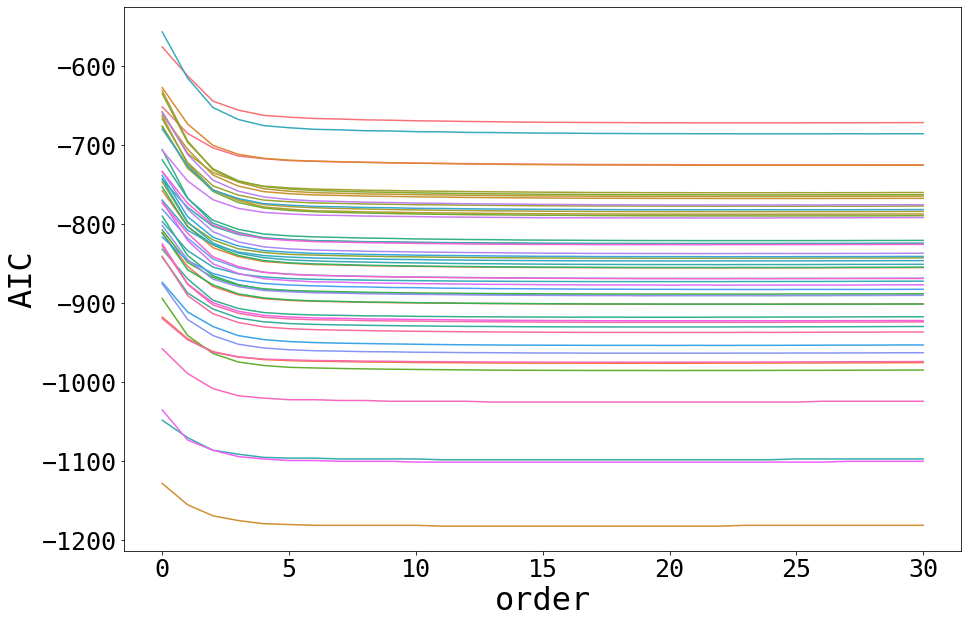

In [3]:
plt.figure(figsize=(15, 10))
sns.lineplot(
    data=orders.reset_index().melt(
        id_vars="order", value_name="AIC", var_name="subject"
    ),
    x="order",
    y="AIC",
    hue="subject",
    legend=False,
)

# Topomaps

In [4]:
topomaps = xr.open_dataarray(os.path.join(RESULTS_FOLDER, "topomaps.nc"))
topomaps = topomaps.set_index({"stack": ["subject_id", "type"]}).unstack()

/var/folders/8l/kg7qz2vn3jn9_bzjm1p_pgq40000gn/T/ipykernel_99550/171016283.py:3: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  os.path.join(DATA_FOLDER, f"{subj_id}_EC.set"), preload=False
/var/folders/8l/kg7qz2vn3jn9_bzjm1p_pgq40000gn/T/ipykernel_99550/171016283.py:3: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  os.path.join(DATA_FOLDER, f"{subj_id}_EC.set"), preload=False


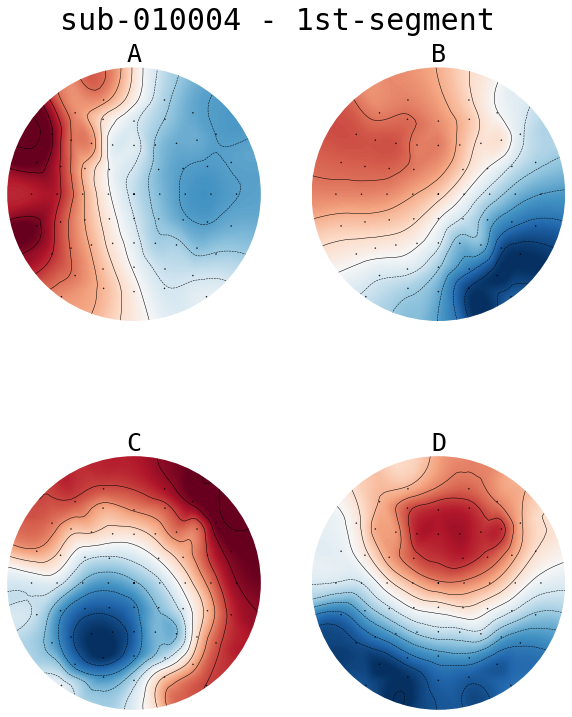

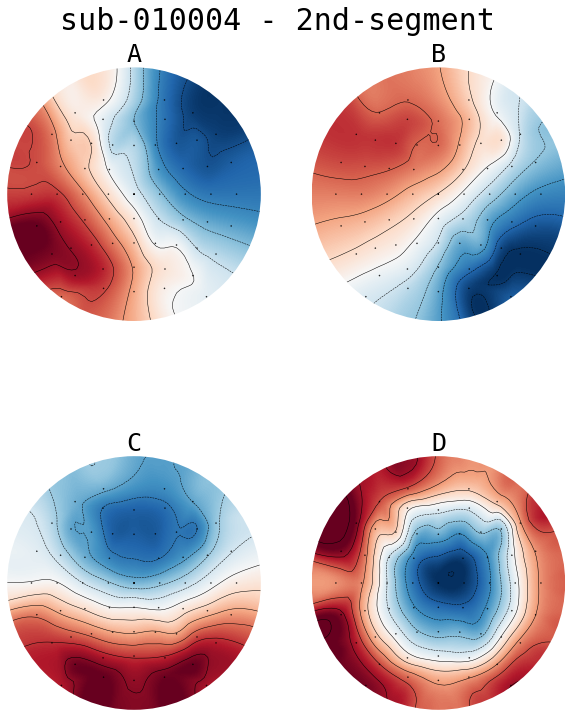

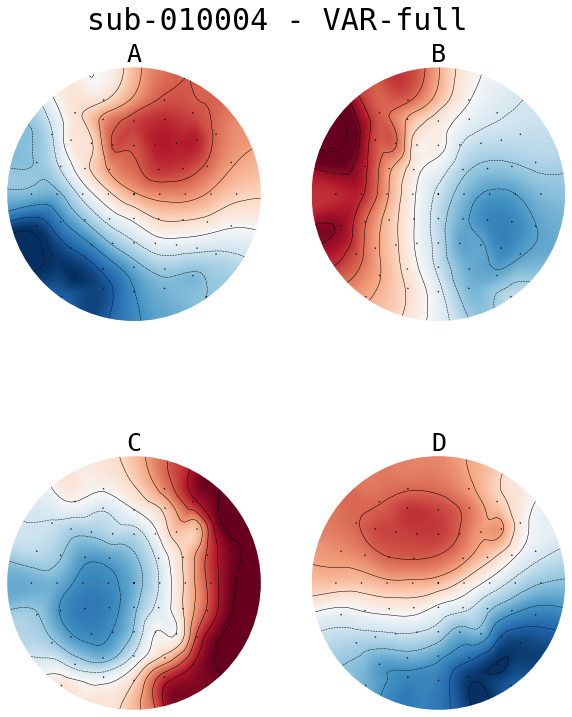

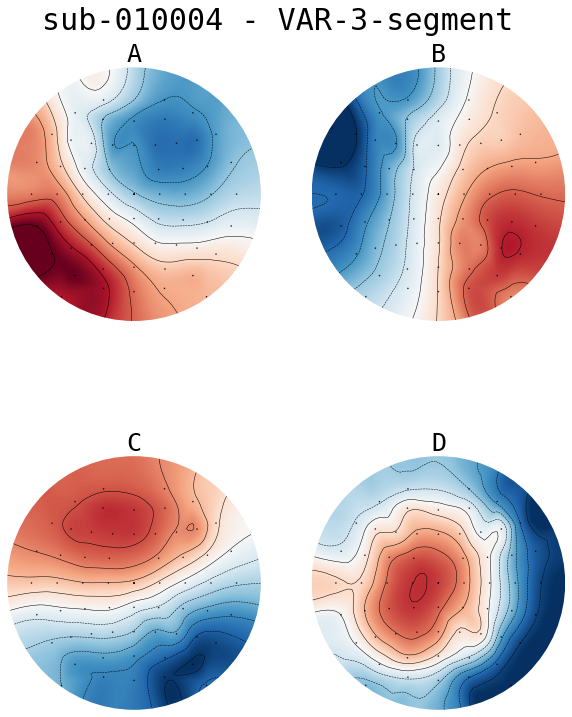

In [5]:
subj_id = "sub-010004"
subj_info = mne.io.read_raw_eeglab(
    os.path.join(DATA_FOLDER, f"{subj_id}_EC.set"), preload=False
)
PLOT_TYPES = ["1st-segment", "2nd-segment", "VAR-full", "VAR-3-segment"]

for plot_type in PLOT_TYPES:
    plot_eeg_topomaps(
        topomaps.sel({"subject_id": subj_id, "type": plot_type})
        .dropna("channels")
        .values,
        subj_info.info,
        title=subj_id + " - " + plot_type,
    )
    plt.show()

# Topomaps accordance

In [6]:
all_corrs = []
TYPES = list(topomaps["type"].values)
for typ1 in TYPES:
    for typ2 in TYPES:
        all_corrs.append(
            xr.corr(
                topomaps.sel({"type": typ1}),
                topomaps.sel({"type": typ2}),
                dim="channels",
            )
            .assign_coords({"type1": typ1, "type2": typ2})
            .expand_dims(["type1", "type2"])
        )

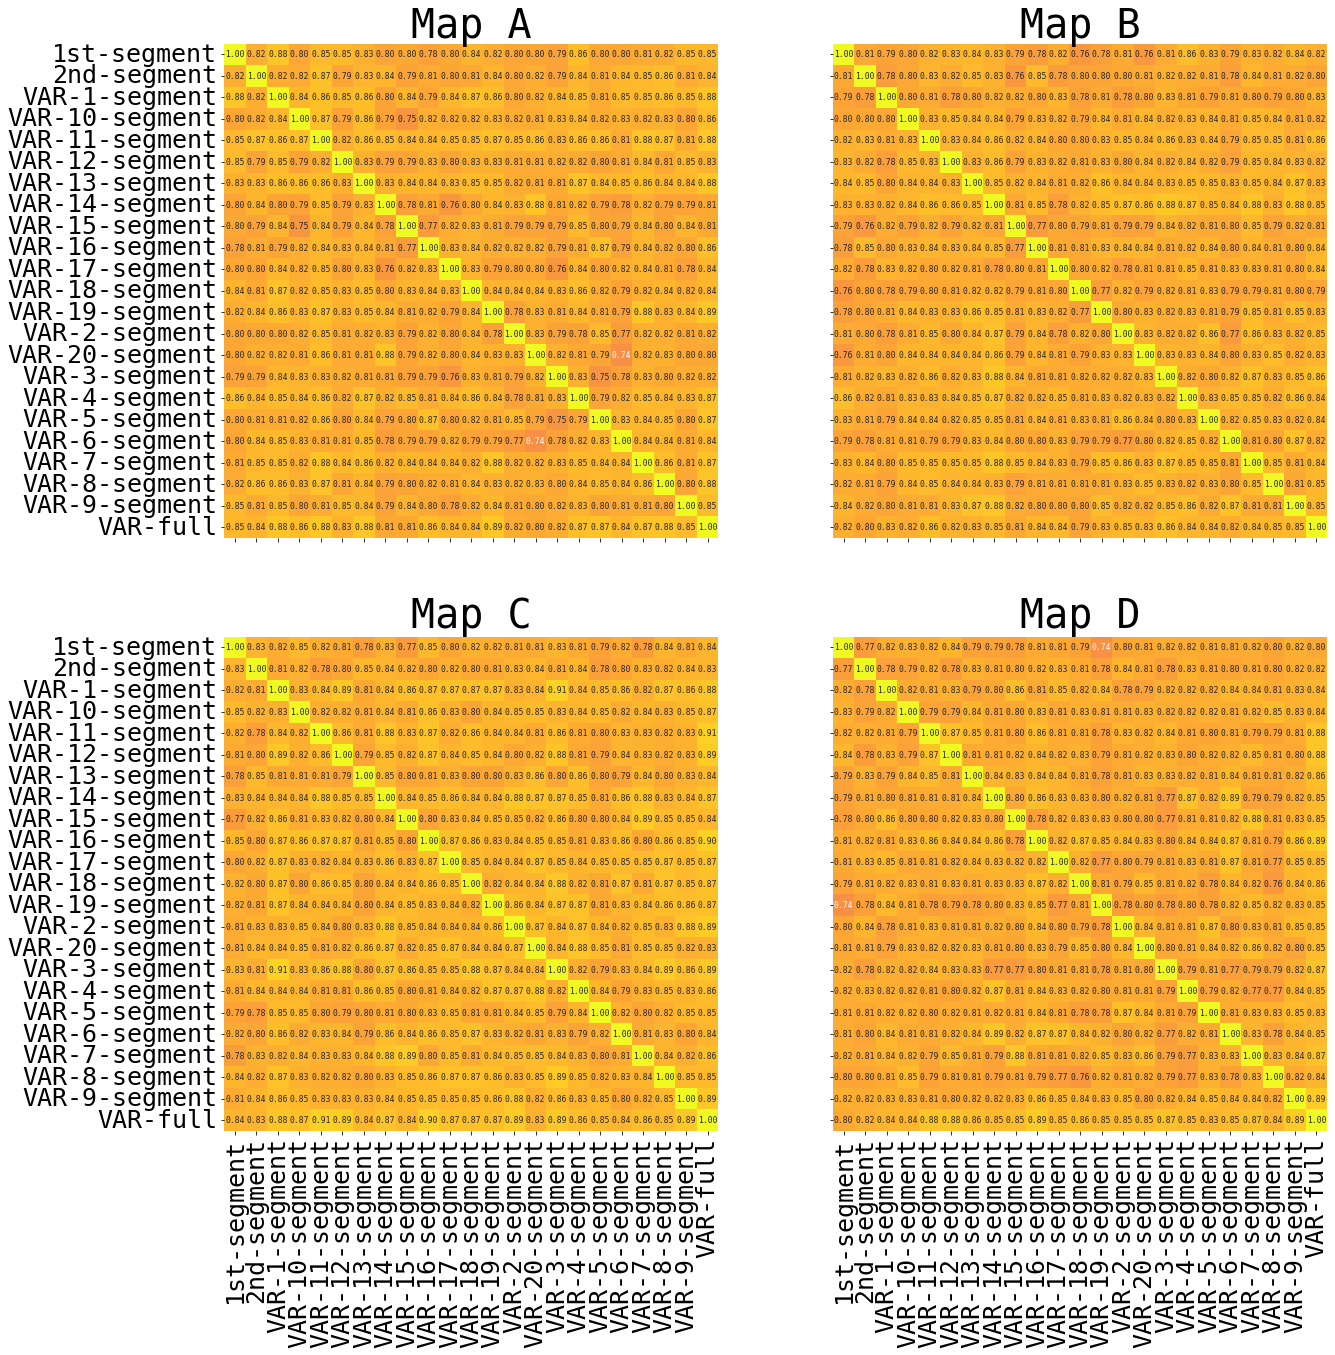

In [7]:
corrs = np.abs(xr.combine_by_coords(all_corrs))
corrs

fig, axs = plt.subplots(
    nrows=2, ncols=2, squeeze=True, figsize=(20, 20), sharey=True, sharex=True
)
axs = axs.flatten()
for i, lamap in enumerate(corrs["latent map"]):
    sns.heatmap(
        corrs.mean(dim="subject_id").sel({"latent map": lamap}),
        square=True,
        ax=axs[i],
        cbar=False,
        cmap="plasma",
        annot_kws={"size": 8},
        annot=True,
        vmin=0,
        vmax=1,
        fmt=".2f",
    )
    axs[i].set_xticks(np.arange(len(TYPES)) + 0.5, TYPES, rotation=90)
    axs[i].set_yticks(np.arange(len(TYPES)) + 0.5, TYPES, rotation=0)
    axs[i].set_title(f"Map {lamap.values}")

In [8]:
TYPES = ["1st-segment", "2nd-segment", "VAR-full"]
SUBJECTS = np.unique(topomaps.coords["subject_id"].values)


def _compute_corr(args):
    topomaps, typ1, typ2, subj1, subj2 = args
    return (
        xr.corr(
            topomaps.sel({"type": typ1, "subject_id": subj1}),
            topomaps.sel({"type": typ2, "subject_id": subj2}),
            dim="channels",
        )
        .assign_coords({"type1": typ1, "type2": typ2, "subj1": subj1, "subj2": subj2})
        .expand_dims(["type1", "type2", "subj1", "subj2"])
    )


all_corrs2 = run_in_parallel(
    _compute_corr,
    [
        (topomaps, typ1, typ2, subj1, subj2)
        for typ1 in TYPES
        for typ2 in TYPES
        for subj1 in SUBJECTS
        for subj2 in SUBJECTS
    ],
)

combined = np.abs(xr.combine_by_coords(all_corrs2))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22500/22500 [01:44<00:00, 216.27it/s]


Text(244.17015810276683, 0.5, 'full VAR $\\to$ 2nd seg.')

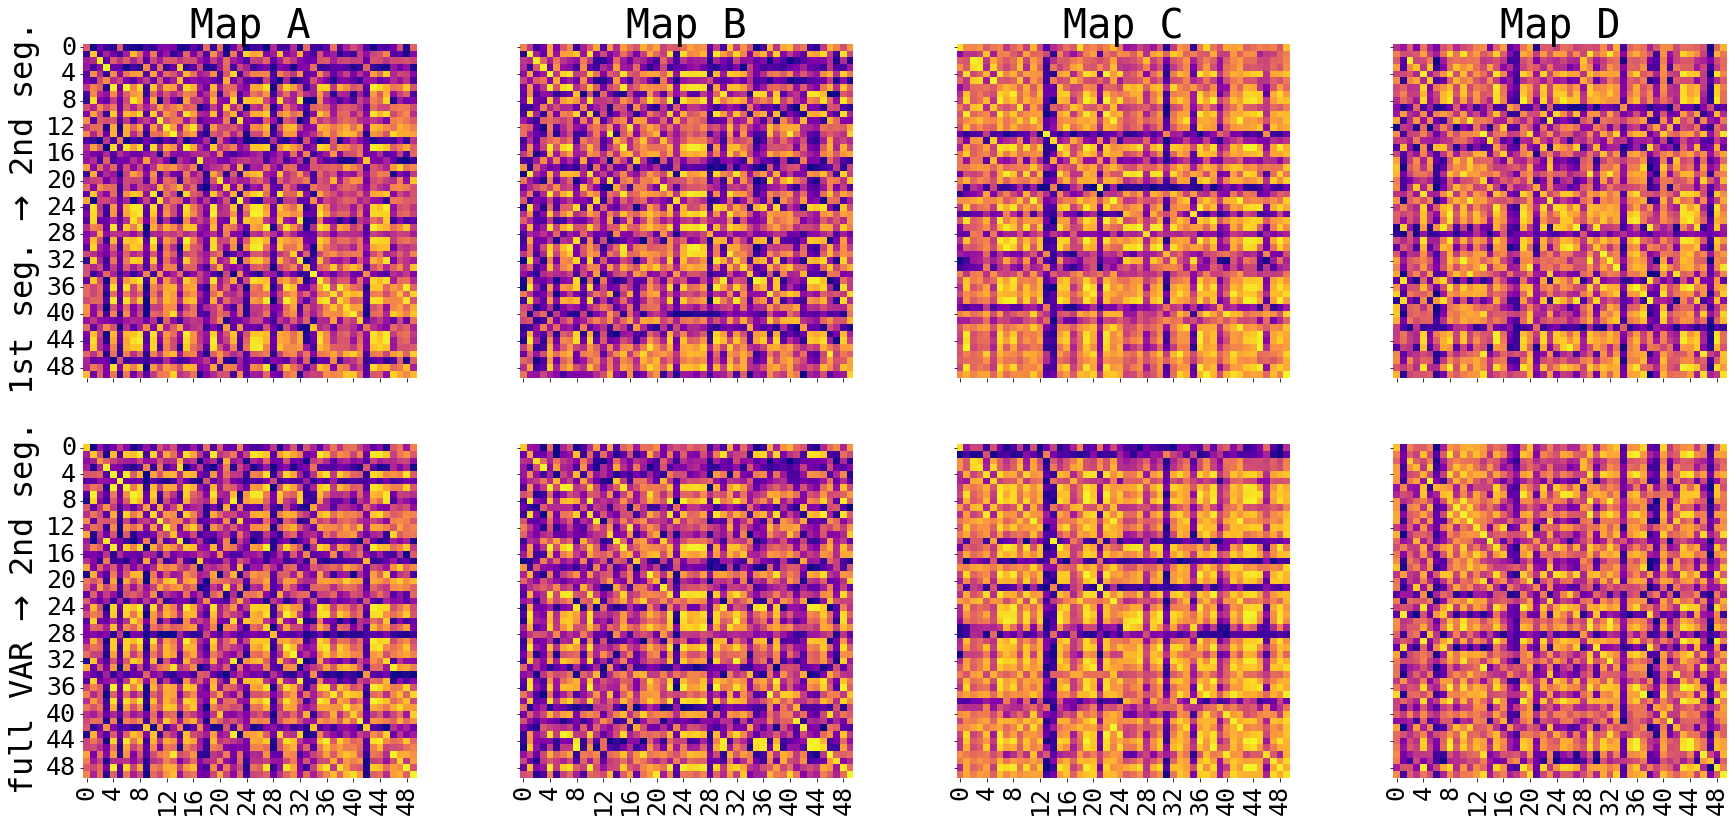

In [9]:
fig, axs = plt.subplots(
    nrows=2, ncols=4, squeeze=True, figsize=(30, 13.5), sharey=True, sharex=True
)

for i, lamap in enumerate(combined["latent map"]):
    for j, howto in enumerate(["1st-segment", "VAR-full"]):
        sns.heatmap(
            combined.sel({"type1": howto, "type2": "2nd-segment", "latent map": lamap}),
            square=True,
            ax=axs[j, i],
            cbar=False,
            cmap="plasma",
            vmin=0,
            vmax=1,
        )
    axs[0, i].set_title(f"Map {lamap.values}")
axs[0, 0].set_ylabel(r"1st seg. $\to$ 2nd seg.")
axs[1, 0].set_ylabel(r"full VAR $\to$ 2nd seg.")

Text(244.17015810276683, 0.5, 'full VAR $\\to$ 2nd seg.')

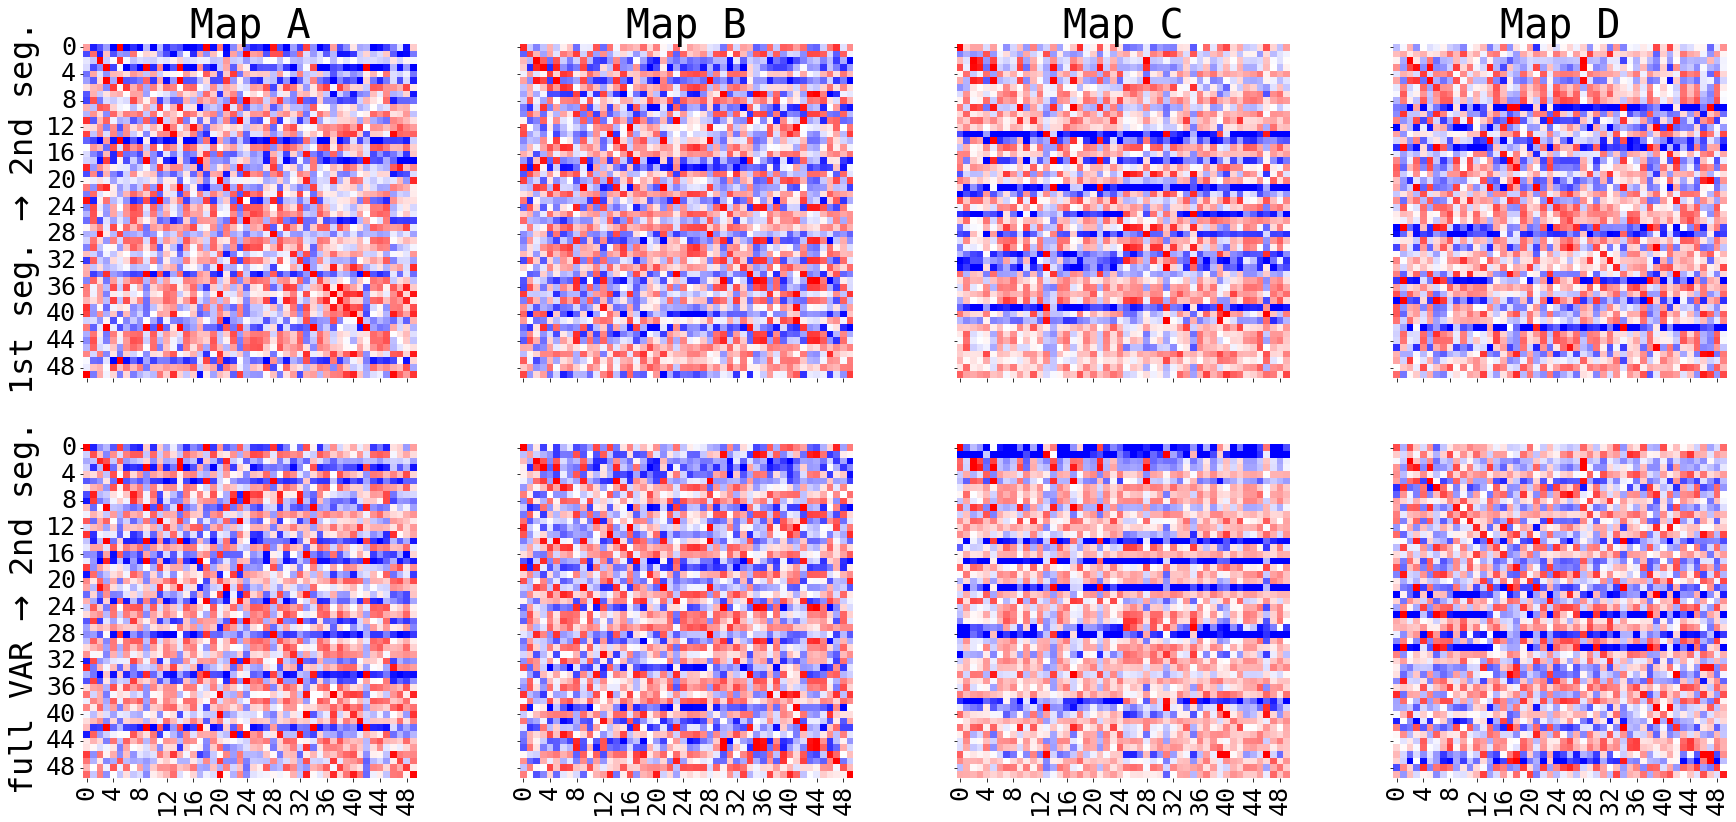

In [10]:
fig, axs = plt.subplots(
    nrows=2, ncols=4, squeeze=True, figsize=(30, 13.5), sharey=True, sharex=True
)
for i, lamap in enumerate(combined["latent map"]):
    for j, howto in enumerate(["1st-segment", "VAR-full"]):
        sns.heatmap(
            zscore(
                combined.sel(
                    {"type1": howto, "type2": "2nd-segment", "latent map": lamap}
                ).values,
                axis=0,
            ),
            square=True,
            ax=axs[j, i],
            cbar=False,
            cmap="bwr",
            vmin=-2.0,
            vmax=2.0,
        )
    axs[0, i].set_title(f"Map {lamap.values}")
axs[0, 0].set_ylabel(r"1st seg. $\to$ 2nd seg.")
axs[1, 0].set_ylabel(r"full VAR $\to$ 2nd seg.")

In [11]:
correct_classif = pd.DataFrame(
    columns=list(combined["latent map"].values), index=["1st-segment", "VAR-full"]
)

for lamap in combined["latent map"]:
    for howto in ["1st-segment", "VAR-full"]:
        correct_classif.loc[howto, str(lamap.values)] = (
            combined.sel(
                {"latent map": lamap, "type1": howto, "type2": "2nd-segment"}
            ).values.argmax(axis=0)
            == np.arange(len(SUBJECTS))
        ).sum()

display(correct_classif)

correct_classif_zs = pd.DataFrame(
    columns=list(combined["latent map"].values), index=["1st-segment", "VAR-full"]
)

for lamap in combined["latent map"]:
    for howto in ["1st-segment", "VAR-full"]:
        correct_classif_zs.loc[howto, str(lamap.values)] = (
            zscore(
                combined.sel(
                    {"latent map": lamap, "type1": howto, "type2": "2nd-segment"}
                ).values,
                axis=0,
            ).argmax(axis=0)
            == np.arange(len(SUBJECTS))
        ).sum()

display(correct_classif_zs)

,A,B,C,D
1st-segment,21,20,19,19
VAR-full,23,21,21,21


,A,B,C,D
1st-segment,21,20,19,19
VAR-full,23,21,21,21


# Static and dynamic stats

In [12]:
static_stats = pd.read_csv(
    os.path.join(RESULTS_FOLDER, "static_stats.csv"), index_col=0
)
static_stats[["subject_id", "type"]] = (
    static_stats["subject_id"].str.split("_", expand=True).drop([1], axis=1)
)
static_stats = static_stats.drop(
    ["filter", "decomposition_type", "use_gfp", "no_states"], axis=1
).sort_values(["subject_id", "type", "latent map"])
# make mean / std from VAR segments
var_means = (
    static_stats.loc[static_stats["type"].str.match("VAR-\d*-segment")]
    .groupby(["subject_id", "latent map"])
    .mean()
    .reset_index()
)
var_means["type"] = "VAR-segments-mean"

static_stats_final = pd.concat(
    [static_stats.loc[~static_stats["type"].str.match("VAR-\d*-segment")], var_means],
    axis=0,
)
static_stats_final = static_stats_final.set_index(["subject_id", "type", "latent map"])
static_stats_final

var_GFP  var_total  template_corr  \
subject_id type              latent map                                       
sub-010002 1st-segment       A           0.684855   0.619612       0.610449   
                             B           0.684855   0.619612       0.965220   
                             C           0.684855   0.619612       0.964178   
                             D           0.684855   0.619612       0.785842   
           2nd-segment       A           0.690051   0.628209       0.962459   
...                                           ...        ...            ...   
sub-010309 VAR-segments-mean D           0.885569   0.833117       0.887013   
sub-010310 VAR-segments-mean A           0.815012   0.746987       0.862974   
                             B           0.815012   0.746987       0.864055   
                             C           0.815012   0.746987       0.894917   
                             D           0.815012   0.746987       0.948169   

                                         coverage  occurrence   lifespan  \
subject_id type              latent map                                    
sub-010002 1st-segment       A           0.271249   19.015399  14.264680   
                             B           0.264582   19.165389  13.805217   
                             C           0.254850   17.615492  14.467360   
                             D           0.209319   15.532298  13.482277   
           2nd-segment       A           0.222585   15.582295  14.284492   
...                                           ...         ...        ...   
sub-010309 VAR-segments-mean D           0.238825   14.975719  15.956555   
sub-010310 VAR-segments-mean A           0.237652   16.088149  14.752384   
                             B           0.256307   15.645673  16.402923   
                             C           0.256034   14.859062  17.225180   
                             D           0.250008   14.284095  17.509707   

                                         transition->A  transition->B  \
subject_id type              latent map                                 
sub-010002 1st-segment       A                0.719587       0.101008   
                             B                0.131519       0.710254   
                             C                0.082134       0.111169   
                             D                0.097165       0.100032   
           2nd-segment       A                0.719976       0.085954   
...                                                ...            ...   
sub-010309 VAR-segments-mean D                0.092290       0.090892   
sub-010310 VAR-segments-mean A                0.727795       0.095271   
                             B                0.108608       0.754719   
                             C                0.059662       0.080784   
                             D                0.085377       0.078070   

                                         transition->C  transition->D  
subject_id type              latent map                                
sub-010002 1st-segment       A                0.095601       0.083804  
                             B                0.089443       0.068783  
                             C                0.723516       0.083181  
                             D                0.099713       0.703090  
           2nd-segment       A                0.088649       0.105421  
...                                                ...            ...  
sub-010309 VAR-segments-mean D                0.072875       0.743943  
sub-010310 VAR-segments-mean A                0.109892       0.067042  
                             B                0.067519       0.069153  
                             C                0.767547       0.092007  
                             D                0.065808       0.770745  

[800 rows x 10 columns]

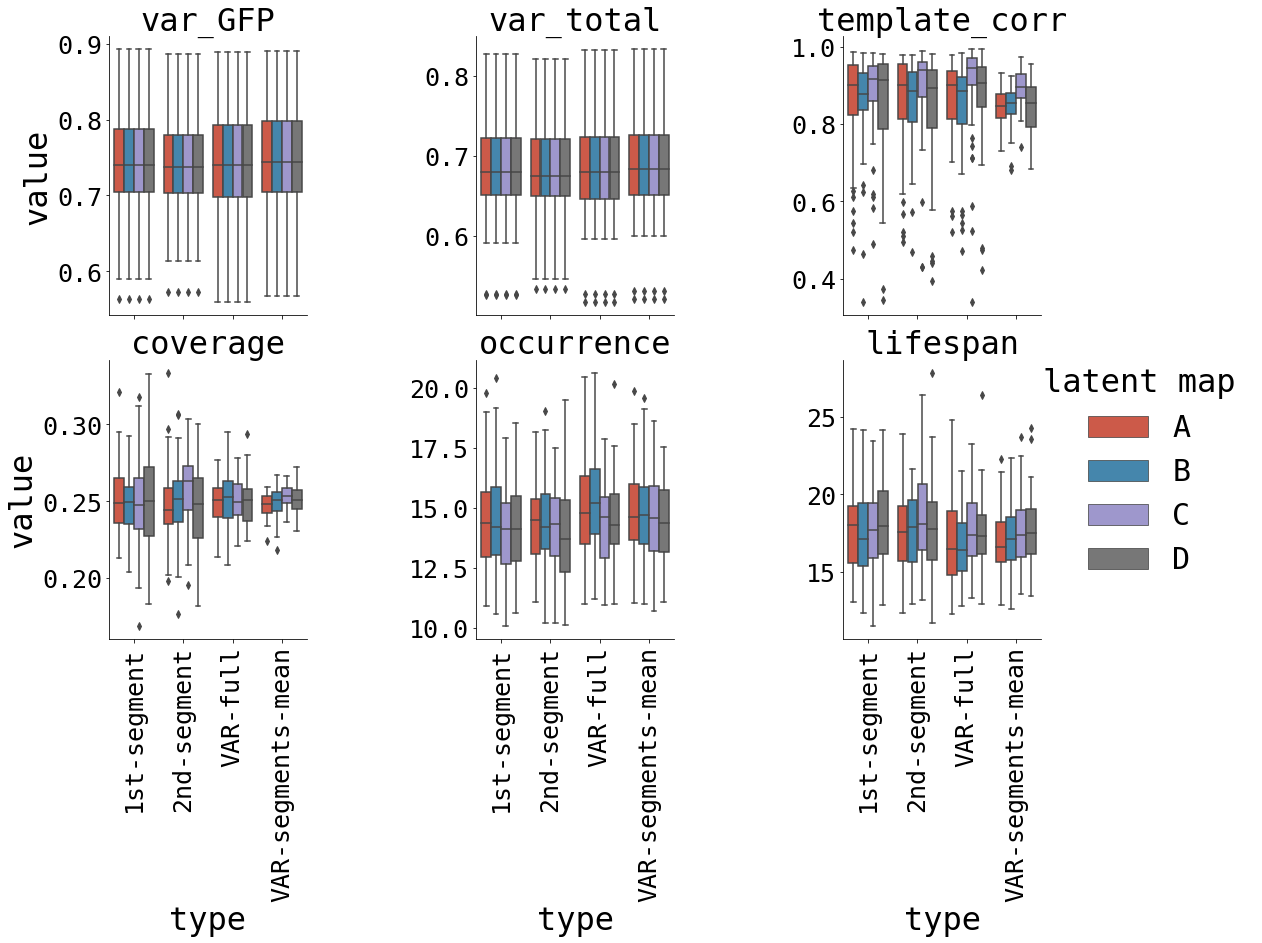

In [13]:
melt = static_stats_final.reset_index().melt(
    id_vars=["latent map", "type", "subject_id"],
    value_vars=[
        "var_GFP",
        "var_total",
        "template_corr",
        "coverage",
        "occurrence",
        "lifespan",
    ],
)
g = sns.catplot(
    data=melt,
    col="variable",
    col_wrap=3,
    hue="latent map",
    x="type",
    y="value",
    kind="box",
    sharey=False,
)
g.set_titles(col_template="{col_name}")
g.set_xticklabels(rotation=90)

In [14]:
STATS_COLS = [
    "var_GFP",
    "var_total",
    "template_corr",
    "coverage",
    "occurrence",
    "lifespan",
    "transition->A",
    "transition->B",
    "transition->C",
    "transition->D",
]

real_data_diff = (
    static_stats[static_stats["type"] == "2nd-segment"]
    .sort_values(["subject_id", "latent map"])
    .set_index(["subject_id", "latent map"])[STATS_COLS]
    - static_stats[static_stats["type"] == "1st-segment"]
    .sort_values(["subject_id", "latent map"])
    .set_index(["subject_id", "latent map"])[STATS_COLS]
)

var_full_diff = (
    static_stats[static_stats["type"] == "2nd-segment"]
    .sort_values(["subject_id", "latent map"])
    .set_index(["subject_id", "latent map"])[STATS_COLS]
    - static_stats[static_stats["type"] == "VAR-full"]
    .sort_values(["subject_id", "latent map"])
    .set_index(["subject_id", "latent map"])[STATS_COLS]
)

all_segments = sorted(
    static_stats["type"][static_stats["type"].str.match(r"VAR-\d*-segment")].unique()
)
all_segments_diffs = []
for segment in all_segments:
    df_temp = (
        static_stats[static_stats["type"] == "2nd-segment"]
        .sort_values(["subject_id", "latent map"])
        .set_index(["subject_id", "latent map"])[STATS_COLS]
        - static_stats[static_stats["type"] == segment]
        .sort_values(["subject_id", "latent map"])
        .set_index(["subject_id", "latent map"])[STATS_COLS]
    )
    df_temp["segment"] = segment
    all_segments_diffs.append(df_temp)
all_segments_diffs = pd.concat(all_segments_diffs)
var_segments_diff_mean = (
    all_segments_diffs.reset_index().groupby(["subject_id", "latent map"]).mean()
)

real_data_diff["diffs"] = "real_data"
var_full_diff["diffs"] = "VAR-full"
var_segments_diff_mean["diffs"] = "VAR-segments"
static_diffs = pd.concat([real_data_diff, var_full_diff, var_segments_diff_mean]).reset_index()

In [15]:
DVS = ["var_GFP", "var_total", "template_corr", "coverage", "occurrence", "lifespan"]

for dv in DVS:
    print(f"== {dv} ==")
    display(pg.rm_anova(data=static_diffs, dv=dv, within="diffs", subject="subject_id"))
    display(pg.pairwise_ttests(data=static_diffs, dv=dv, within="diffs", subject="subject_id", padjust="fdr_by"))

== var_GFP ==


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,diffs,2,98,5.98461,0.00353,0.010106,0.509004


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,15.257256,49.0,two-sided,3.028252e-20,1.665539e-19,fdr_by,1.562e+17,0.135572
1,diffs,VAR-full,real_data,True,True,-1.063350,49.0,two-sided,2.928355e-01,5.368651e-01,fdr_by,0.262,-0.096711
2,diffs,VAR-segments,real_data,True,True,-2.851184,49.0,two-sided,6.358000e-03,1.748450e-02,fdr_by,5.558,-0.256094


== var_total ==


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,diffs,2,98,3.736609,0.027297,0.006152,0.502775


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,23.072039,49.0,two-sided,5.683498e-28,3.125924e-27,fdr_by,5.251e+24,0.112907
1,diffs,VAR-full,real_data,True,True,-0.714436,49.0,two-sided,4.783472e-01,8.769699e-01,fdr_by,0.196,-0.064407
2,diffs,VAR-segments,real_data,True,True,-2.213277,49.0,two-sided,3.156619e-02,8.680701e-02,fdr_by,1.423,-0.197810


== template_corr ==


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,diffs,2,98,0.982431,0.378056,0.004362,0.678954


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,-1.609412,49.0,two-sided,0.113951,0.626730,fdr_by,0.512,-0.140447
1,diffs,VAR-full,real_data,True,True,-0.936034,49.0,two-sided,0.353846,0.973078,fdr_by,0.233,-0.130425
2,diffs,VAR-segments,real_data,True,True,0.001896,49.0,two-sided,0.998495,1.000000,fdr_by,0.154,0.000195


== coverage ==


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,diffs,2,98,2.411873,0.094951,0.013503,0.731359


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,-2.539328,49.0,two-sided,0.014331,0.078819,fdr_by,2.762,-0.265436
1,diffs,VAR-full,real_data,True,True,-1.444851,49.0,two-sided,0.154865,0.425878,fdr_by,0.407,-0.222172
2,diffs,VAR-segments,real_data,True,True,0.163222,49.0,two-sided,0.871015,1.000000,fdr_by,0.156,0.018878


== occurrence ==


,Source,ddof1,ddof2,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,diffs,2,98,49.235708,1.579095e-15,2.461164e-12,0.142489,0.757519,False,0.679901,0.000095


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,-3.632234,49.0,two-sided,6.714885e-04,1.231062e-03,fdr_by,40.716,-0.217565
1,diffs,VAR-full,real_data,True,True,-8.221433,49.0,two-sided,8.779314e-11,4.828623e-10,fdr_by,1.143e+08,-0.991924
2,diffs,VAR-segments,real_data,True,True,-6.474429,49.0,two-sided,4.326588e-08,1.189812e-07,fdr_by,3.144e+05,-0.743501


== lifespan ==


,Source,ddof1,ddof2,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,diffs,2,98,49.696568,1.255473e-15,4.415650e-11,0.133975,0.657519,False,0.479132,2.142489e-08


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,4.086988,49.0,two-sided,1.616927e-04,2.964366e-04,fdr_by,147.884,0.188723
1,diffs,VAR-full,real_data,True,True,7.975489,49.0,two-sided,2.082730e-10,1.145502e-09,fdr_by,5.007e+07,0.954693
2,diffs,VAR-segments,real_data,True,True,6.450120,49.0,two-sided,4.718372e-08,1.297552e-07,fdr_by,2.896e+05,0.729237


In [16]:
dynamic_stats = pd.read_csv(
    os.path.join(RESULTS_FOLDER, "dynamic_stats.csv"), index_col=0
)
dynamic_stats[["subject_id", "type"]] = (
    dynamic_stats["subject_id"].str.split("_", expand=True).drop([1], axis=1)
)
dynamic_stats = dynamic_stats.sort_values(["subject_id", "type"])
# make mean / std from VAR segments
var_means = (
    dynamic_stats.loc[dynamic_stats["type"].str.match("VAR-\d*-segment")]
    .groupby(["subject_id"])
    .mean()
    .reset_index()
)
var_means["type"] = "VAR-segments-mean"

dynamic_stats_final = pd.concat(
    [dynamic_stats.loc[~dynamic_stats["type"].str.match("VAR-\d*-segment")], var_means],
    axis=0,
)
dynamic_stats_final = dynamic_stats_final.set_index(["subject_id", "type"])
dynamic_stats_final

mixing time   entropy  max entropy  \
subject_id type                                                    
sub-010002 1st-segment           2.660394  1.993006          2.0   
           2nd-segment           2.750218  1.994790          2.0   
           VAR-full              2.689807  1.990558          2.0   
sub-010004 1st-segment           3.615836  1.984900          2.0   
           2nd-segment           3.728906  1.991836          2.0   
...                                   ...       ...          ...   
sub-010298 VAR-segments-mean     4.589373  1.993768          2.0   
sub-010302 VAR-segments-mean     2.977400  1.994965          2.0   
sub-010303 VAR-segments-mean     3.391620  1.996528          2.0   
sub-010309 VAR-segments-mean     3.471798  1.990587          2.0   
sub-010310 VAR-segments-mean     3.320460  1.995379          2.0   

                              entropy_rate  MC entropy rate  AIF 1st peak  
subject_id type                                                            
sub-010002 1st-segment            1.253384         1.309297         100.0  
           2nd-segment            1.246591         1.298560          36.0  
           VAR-full               1.289279         1.336408          36.0  
sub-010004 1st-segment            1.028429         1.060179          48.0  
           2nd-segment            1.025012         1.056550          56.0  
...                                    ...              ...           ...  
sub-010298 VAR-segments-mean      0.924043         0.948071          68.2  
sub-010302 VAR-segments-mean      1.191653         1.240022          40.0  
sub-010303 VAR-segments-mean      1.117561         1.158310          42.4  
sub-010309 VAR-segments-mean      1.085643         1.128340          52.0  
sub-010310 VAR-segments-mean      1.123270         1.173829          48.0  

[200 rows x 6 columns]

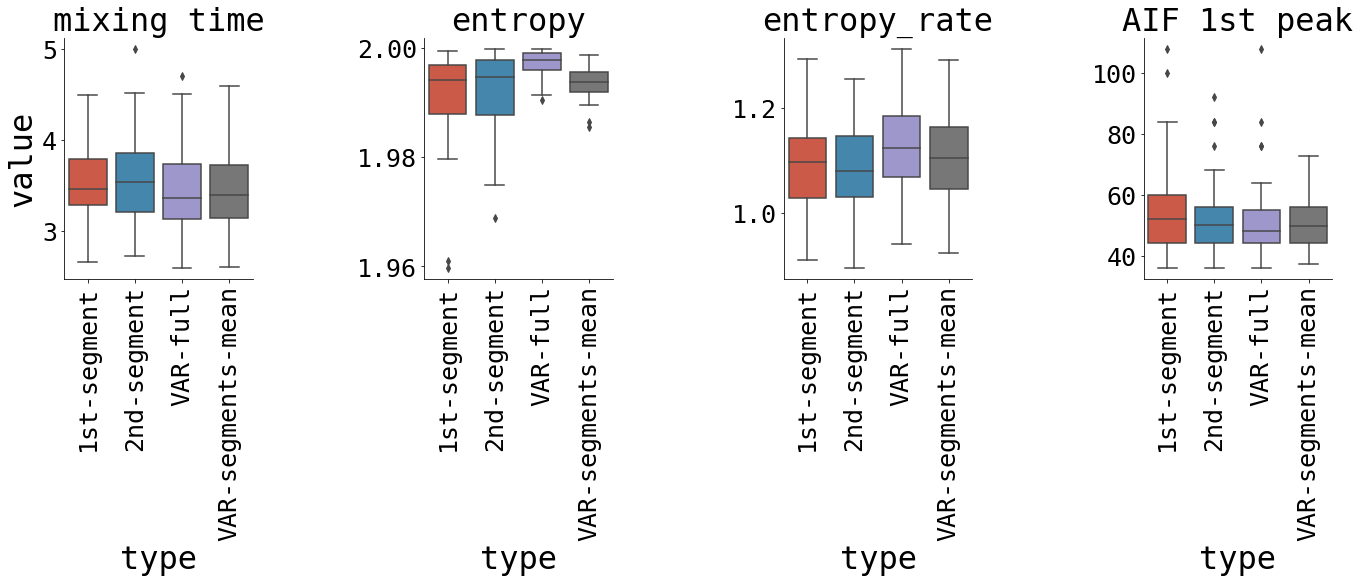

In [17]:
g = sns.catplot(
    data=dynamic_stats_final.reset_index().melt(
        id_vars=["subject_id", "type"],
        value_vars=["mixing time", "entropy", "entropy_rate", "AIF 1st peak"],
    ),
    col="variable",
    col_wrap=4,
    x="type",
    y="value",
    kind="box",
    sharey=False,
)
g.set_titles(col_template="{col_name}")
g.set_xticklabels(rotation=90)

In [18]:
dynamic_stats

,subject_id,mixing time,entropy,max entropy,entropy_rate,MC entropy rate,AIF 1st peak,type
0,sub-010002,2.660394,1.993006,2.0,1.253384,1.309297,100.0,1st-segment
0,sub-010002,2.750218,1.994790,2.0,1.246591,1.298560,36.0,2nd-segment
0,sub-010002,2.675752,1.991917,2.0,1.250652,1.307669,36.0,VAR-1-segment
0,sub-010002,2.776497,1.990915,2.0,1.264825,1.323187,36.0,VAR-10-segment
0,sub-010002,2.549845,1.987974,2.0,1.294715,1.360233,36.0,VAR-11-segment
...,...,...,...,...,...,...,...,...
0,sub-010310,3.302975,1.998236,2.0,1.125829,1.178417,48.0,VAR-6-segment
0,sub-010310,3.326296,1.997988,2.0,1.122446,1.170991,48.0,VAR-7-segment
0,sub-010310,3.242245,1.995321,2.0,1.135397,1.187442,48.0,VAR-8-segment
0,sub-010310,3.296428,1.998884,2.0,1.125553,1.174856,48.0,VAR-9-segment


In [19]:
STATS_COLS = [
    "mixing time",
    "entropy",
    "entropy_rate",
    "AIF 1st peak",
]

real_data_diff = (
    dynamic_stats[dynamic_stats["type"] == "2nd-segment"]
    .sort_values(["subject_id"])
    .set_index(["subject_id"])[STATS_COLS]
    - dynamic_stats[dynamic_stats["type"] == "1st-segment"]
    .sort_values(["subject_id"])
    .set_index(["subject_id"])[STATS_COLS]
)

var_full_diff = (
    dynamic_stats[dynamic_stats["type"] == "2nd-segment"]
    .sort_values(["subject_id"])
    .set_index(["subject_id"])[STATS_COLS]
    - dynamic_stats[dynamic_stats["type"] == "VAR-full"]
    .sort_values(["subject_id"])
    .set_index(["subject_id"])[STATS_COLS]
)

all_segments = sorted(
    dynamic_stats["type"][dynamic_stats["type"].str.match(r"VAR-\d*-segment")].unique()
)
all_segments_diffs = []
for segment in all_segments:
    df_temp = (
        dynamic_stats[dynamic_stats["type"] == "2nd-segment"]
        .sort_values(["subject_id"])
        .set_index(["subject_id"])[STATS_COLS]
        - dynamic_stats[dynamic_stats["type"] == segment]
        .sort_values(["subject_id"])
        .set_index(["subject_id"])[STATS_COLS]
    )
    df_temp["segment"] = segment
    all_segments_diffs.append(df_temp)
all_segments_diffs = pd.concat(all_segments_diffs)
var_segments_diff_mean = (
    all_segments_diffs.reset_index().groupby(["subject_id"]).mean()
)

real_data_diff["diffs"] = "real_data"
var_full_diff["diffs"] = "VAR-full"
var_segments_diff_mean["diffs"] = "VAR-segments"
dynamic_diffs = pd.concat([real_data_diff, var_full_diff, var_segments_diff_mean]).reset_index()

In [20]:
dynamic_diffs

,subject_id,mixing time,entropy,entropy_rate,AIF 1st peak,diffs
0,sub-010002,0.089824,0.001784,-0.006793,-64.0,real_data
1,sub-010004,0.113071,0.006937,-0.003416,8.0,real_data
2,sub-010007,0.050625,0.003092,0.005935,0.0,real_data
3,sub-010020,-0.076451,-0.014174,-0.018896,4.0,real_data
4,sub-010024,0.129185,-0.000467,0.014649,0.0,real_data
...,...,...,...,...,...,...
145,sub-010298,-0.075506,0.003514,0.006567,-0.2,VAR-segments
146,sub-010302,0.174682,0.002578,-0.001162,0.0,VAR-segments
147,sub-010303,0.143715,-0.003668,-0.018257,1.6,VAR-segments
148,sub-010309,0.330225,0.007190,-0.038949,0.0,VAR-segments


In [21]:
DVS = ["mixing time", "entropy", "entropy_rate", "AIF 1st peak"]

for dv in DVS:
    print(f"== {dv} ==")
    display(pg.rm_anova(data=dynamic_diffs, dv=dv, within="diffs", subject="subject_id"))
    display(pg.pairwise_ttests(data=dynamic_diffs, dv=dv, within="diffs", subject="subject_id", padjust="fdr_by"))

== mixing time ==


,Source,ddof1,ddof2,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,diffs,2,98,23.040095,6.287360e-09,2.102945e-07,0.067174,0.77413,False,0.708228,0.000254


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,2.042647,49.0,two-sided,0.046487,0.085225,fdr_by,1.036,0.142255
1,diffs,VAR-full,real_data,True,True,5.586292,49.0,two-sided,0.000001,0.000006,fdr_by,1.624e+04,0.596052
2,diffs,VAR-segments,real_data,True,True,4.613431,49.0,two-sided,0.000029,0.000079,fdr_by,721.826,0.464512


== entropy ==


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,diffs,2,98,16.560438,6.370263e-07,0.071597,0.605117


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,-8.123165,49.0,two-sided,1.239155e-10,6.815353e-10,fdr_by,8.222e+07,-0.485826
1,diffs,VAR-full,real_data,True,True,-4.593455,49.0,two-sided,3.069791e-05,8.441926e-05,fdr_by,678.644,-0.612488
2,diffs,VAR-segments,real_data,True,True,-1.763703,49.0,two-sided,8.401634e-02,1.540300e-01,fdr_by,0.647,-0.223198


== entropy_rate ==


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,diffs,2,98,159.141284,1.659796e-31,0.319936,0.550715


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,-26.558450,49.0,two-sided,9.503224e-31,5.226773e-30,fdr_by,2.701e+27,-0.764335
1,diffs,VAR-full,real_data,True,True,-14.197451,49.0,two-sided,5.444703e-19,1.497293e-18,fdr_by,9.443e+15,-1.699548
2,diffs,VAR-segments,real_data,True,True,-7.883722,49.0,two-sided,2.878073e-10,5.276468e-10,fdr_by,3.677e+07,-0.871052


== AIF 1st peak ==


,Source,ddof1,ddof2,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,diffs,2,98,2.305597,0.105084,0.123055,0.015267,0.706504,False,0.584579,0.000003


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,-0.218143,49.0,two-sided,0.828224,1.000000,fdr_by,0.157,-0.022589
1,diffs,VAR-full,real_data,True,True,1.440974,49.0,two-sided,0.155952,0.428868,fdr_by,0.405,0.226744
2,diffs,VAR-segments,real_data,True,True,1.884422,49.0,two-sided,0.065447,0.359959,fdr_by,0.788,0.264845
